# 8.5 Variaciones de Adam

In [7]:
import os.path
if  not os.path.isfile("OPT_helper.py"):
    !wget https://github.com/deeplearning-itba/optimizadores/raw/master/OPT_helper.py

In [8]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo
from sklearn.model_selection import train_test_split
import os.path
import keras
import numpy as np
from matplotlib import pyplot as plt
import OPT_helper
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  
/Users/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


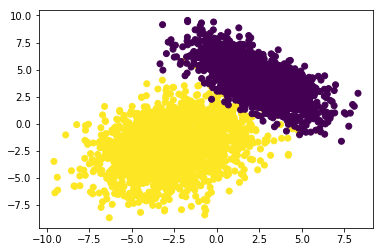

In [9]:
np.random.seed(432)
X = np.vstack([np.random.multivariate_normal([-2.5,-2], [[2,5],[5,1]], 2000),
             np.random.multivariate_normal([2.5,4], [[2,-3],[-3,2]], 2000)])
y = np.hstack([np.ones(2000),
             np.zeros(2000)])

#X=df[['Peso','Altura']].values
#y=df['Genero'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [3]:
y_test

array([1., 0., 1., ..., 0., 0., 0.])

# Adamax

- Es una variante de Adam, que utiliza la norma infinita para escalar el learning rate, en vez de utilizar la norma 2.
- Funciona mejor para datos de alta esparcidad.

$$ m_t=\beta_1  m_{t-1} + (1-\beta_1)g_t $$
$$ v_t=\max \left( \beta_2  v_{t-1}, g_t \right) $$

Los autores recomiendan $\beta_1=0.9$, $\beta_2=0.999$ y $\eta=0.002$.  

# Nadam

- Es adam pero en vez de utilizar momento de orden uno, utiliza momento de nesterov (evalúa el gradiente después de actualizar el factor de inercia).

# Red Neuronal de 1 capa

In [10]:
# Esta función recibe un modelo y devuelve los pesos que se quieren loggear
def get_weights(model):
    weights=list()
    
    for layer in model.layers[0:]:
        weights.append([layer.get_weights()[1][0],
                        layer.get_weights()[0][0][0],
                        layer.get_weights()[0][1][0]])
    
    return weights

def set_weights(model,w0,w1,w2):
    weights = model.layers[0].get_weights()
    weights[0][0][0] = w1
    weights[0][1][0] = w2
    weights[1][0] = w0
    model.layers[0].set_weights(weights)
    
def reset_weights(model):
    weights = model.layers[-1].get_weights()
    weights[0][0] = weights[0][0] * 0
    model.layers[-1].set_weights(weights)

Instructions for updating:
Use tf.cast instead.

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.05.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.599999814061448e-05.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 3.199999628122896e-06.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 6.399999165296323e-07.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.2799998785339995e-07.

Epoch 00051: ReduceLROnPlateau reducing learning rate to 2.5599996433811613e-08.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 5.1199993578165965e-09.

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.023999907090456e

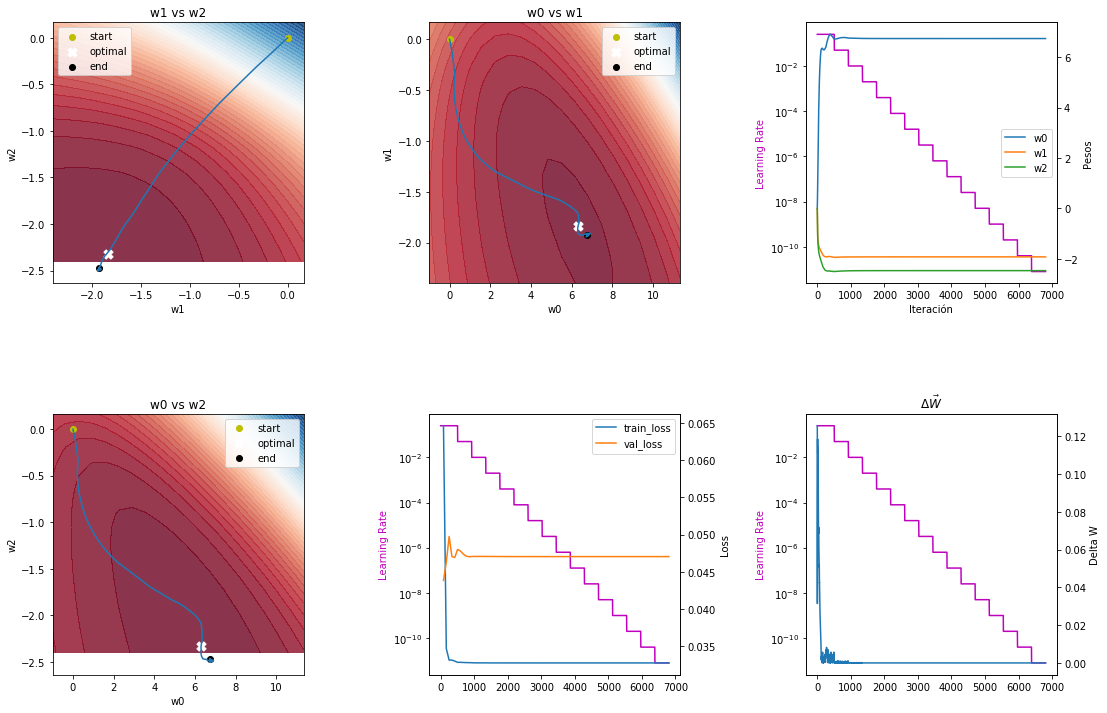

Epoch 00081: early stopping


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:], activation='sigmoid', 
                kernel_initializer='normal', name='salida'))

optimizer = optimizers.Adamax(lr=0.25,beta_1=0.99,beta_2=0.999,
                               epsilon=1e-8, 
                               decay=0.0,)

model.compile(loss = 'binary_crossentropy', optimizer=optimizer)
earlyStopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=80, verbose=1, restore_best_weights=True)

reduceLR = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2, 
                           patience=5, 
                           verbose=1, 
                           min_delta=0, 
                           cooldown=0, min_lr=0)

logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

history = model.fit(x_train, 
          y_train ,
          epochs=200,
          batch_size=32, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping, reduceLR],
          shuffle=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:], activation='sigmoid', 
                kernel_initializer='zeros', name='salida'))

optimizer = optimizers.Nadam(lr=0.25,
                             beta_1=0.9,
                             beta_2=0.999,
                             epsilon=1e-8)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

earlyStopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=80, verbose=1, restore_best_weights=True)

reduceLR = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.1, 
                           patience=5, 
                           verbose=1, 
                           min_delta=0, 
                           cooldown=0, min_lr=0)

logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

history = model.fit(x_train, 
          y_train ,
          epochs=4000,
          batch_size=256, 
          verbose=0, 
          validation_data=(x_train, y_train), 
          callbacks=[logWeights, earlyStopping, reduceLR],
          shuffle=False)

In [61]:
get_weights(model)

[[6.1743593, -1.7648771, -2.0008678]]

In [4]:
import matplotlib.animation as animation
import pickle
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

def make_animation(surface_filename,logWeights):
    pesos_min = np.array(logWeights.history["weights_0"]).min()
    pesos_max = np.array(logWeights.history["weights_0"]).max()
    delta = np.abs(np.array(logWeights.history["weights_0"])[1:,0]-np.array(logWeights.history["weights_0"])[:-1,0])
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=720)

    with open(surface_filename, 'rb') as f:
        [w12,w21,w01,w10,w02,w20,J12,J01,J02]=pickle.load(f)
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])        
    
    fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(18, 12))
    ax1.contourf(w12, w21, J12, 50, cmap=cm, alpha=.8)
    ax2.contourf(w01, w10, J01, 50, cmap=cm, alpha=.8)
    ax4.contourf(w02, w20, J02, 50, cmap=cm, alpha=.8)  
    lr = np.array(logWeights.history["lr"])
    idx = np.arange(len(lr))
    decay = 1 / (1 + (idx * logWeights.history["lr_decay"][0]))
    lr = lr * decay
    ax3.semilogy(lr,color="m")
    ax3_aux = ax3.twinx()  # instantiate a second axes that shares the same x-axis
    ax5.semilogy(lr,color="m")
    ax5_aux = ax5.twinx() 
    
    ax1.scatter(logWeights.history["weights_0"][0][1],logWeights.history["weights_0"][0][2],c='y',label="start")
    ax1.scatter(logWeights.w1_opt,logWeights.w2_opt,marker='X',s=85,c='w',label="optimal")
    ax2.scatter(logWeights.history["weights_0"][0][0],logWeights.history["weights_0"][0][1],c='y',label="start")
    ax2.scatter(logWeights.w0_opt,logWeights.w1_opt,marker='X',s=85,c='w',label="optimal")
    ax4.scatter(logWeights.history["weights_0"][0][0],logWeights.history["weights_0"][0][2],c='y',label="start")
    ax4.scatter(logWeights.w0_opt,logWeights.w2_opt,marker='X',s=85,c='w',label="optimal")
    ax6.semilogy(lr,color="m")
    ax6.set_title("$\\Delta \\vec W $")
    ax6_aux = ax6.twinx() 
    ax1.set_title('w1 vs w2')
    ax1.set_xlabel('w1')
    ax1.set_ylabel('w2')
    ax2.set_title('w0 vs w1')
    ax2.set_xlabel('w0')
    ax2.set_ylabel('w1')
    ax4.set_title('w0 vs w2')
    ax4.set_xlabel('w0')
    ax4.set_ylabel('w2')
    ax3.set_xlabel('Iteración')
    ax3.set_ylabel('Learning Rate',color="m")
    ax5.set_ylabel('Learning Rate',color="m")
    ax6.set_ylabel('Learning Rate',color="m")
    ax3_aux.set_xlabel('Iteración')
    ax3_aux.set_ylabel('Pesos')
    ax5_aux.set_xlabel('Epoch')
    ax5_aux.set_ylabel('Loss')
    ax6_aux.set_ylabel('Delta W')
    ax3_aux.legend()
    ax3_aux.set_ylim(pesos_min,pesos_max)
    ax6_aux.set_ylim(0,delta.max())
    ax5_aux.legend()
    ax1.legend()
    ax2.legend()
    ax4.legend()
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    x = list(range(1000))
    loss = np.interp(x, logWeights.x, np.array(logWeights.losses))
    val_loss = np.interp(x, logWeights.x, np.array(logWeights.val_losses))
    loss_max = np.hstack([loss, val_loss]).max()
    ax5_aux.set_ylim(0, loss.max())
    
    ln1, = ax1.plot([],[],linewidth=5)
    ln2, = ax2.plot([],[],linewidth=5)
    ln4, = ax4.plot([],[],linewidth=5)
    ln3_1, = ax3_aux.plot([],[],linewidth=2)
    ln3_2, = ax3_aux.plot([],[],linewidth=2)
    ln3_3, = ax3_aux.plot([],[],linewidth=2)
    ln6, = ax6_aux.plot([],[],linewidth=2)
    ln5_1, = ax5_aux.plot([],[],linewidth=2)
    ln5_2, = ax5_aux.plot([],[],linewidth=2)
    sc1, = ax1.plot([],[],'go',c='k',label="end")
    sc2, = ax2.plot([],[],'go',c='k',label="end")
    sc4, = ax4.plot([],[],'go',c='k',label="end")
    
    def animate(i):
        print("\r{}".format(i),end="")
        ln1.set_data(np.array(logWeights.history["weights_0"])[:i,1],np.array(logWeights.history["weights_0"])[:i,2])
        ln2.set_data(np.array(logWeights.history["weights_0"])[:i,0],np.array(logWeights.history["weights_0"])[:i,1])
        ln4.set_data(np.array(logWeights.history["weights_0"])[:i,0],np.array(logWeights.history["weights_0"])[:i,2])
        ln5_1.set_data(x[:i],loss[:i])
        ln5_2.set_data(x[:i],val_loss[:i])
        ln6.set_data(x[:i],delta[:i])
        ln3_1.set_data(x[:i],np.array(logWeights.history["weights_0"])[:i,0])
        ln3_2.set_data(x[:i],np.array(logWeights.history["weights_0"])[:i,1])
        ln3_3.set_data(x[:i],np.array(logWeights.history["weights_0"])[:i,2])
        sc1.set_data(np.array(logWeights.history["weights_0"])[i,1],np.array(logWeights.history["weights_0"])[i,2])
        sc2.set_data(np.array(logWeights.history["weights_0"])[i,0],np.array(logWeights.history["weights_0"])[i,1])
        sc4.set_data(np.array(logWeights.history["weights_0"])[i,0],np.array(logWeights.history["weights_0"])[i,2])
        #     ax2.plot(np.array(logWeights.history["weights_0"])[:,0],np.array(logWeights.history["weights_0"])[:,1])
#     ax4.plot(np.array(logWeights.history["weights_0"])[:,0],np.array(logWeights.history["weights_0"])[:,2])
#     ax3_aux.plot(np.array(logWeights.history["weights_0"])[:,0],label='w0')
#     ax3_aux.plot(np.array(logWeights.history["weights_0"])[:,1],label='w1')
#     ax3_aux.plot(np.array(logWeights.history["weights_0"])[:,2],label='w2')
#     ax5_aux.plot(logWeights.x,np.array(logWeights.losses),label='train_loss')
#     ax5_aux.plot(logWeights.x,np.array(logWeights.val_losses),label='val_loss')
#     ax6_aux.plot(np.abs(np.array(logWeights.history["weights_0"])[1:,0]-np.array(logWeights.history["weights_0"])[:-1,0]))
    ani = animation.FuncAnimation(fig, animate, frames=1000, repeat=True,save_count=50)
    ani.save('videos/prueba.mp4', writer=writer)

In [5]:
make_animation(surface_filename="surface.pck", logWeights=logWeights)

NameError: name 'logWeights' is not defined